# Project Phase II

### Research Question(s)

A person's life expentancy in a given country can be predicted by different metrics of their country, including violent crime rates, health care, diet, economic development, genetics, and happiness level.

# Data Collection and Cleaning

Have an initial draft of your data cleaning
appendix. Document every step that takes your raw data file(s) and turns it
into the analysis-ready data set that you would submit with your final
project. Include text cells describing your data collection (downloading,
scraping, surveys, etc), and text cells describing any additional data
curation/cleaning (merging data frames, filtering, transformations of
variables, etc). Include code cells for data curation/cleaning, but not
collection. Note: You should be saving data in intermediate files at several
points through this process so that you are not starting from scratch every
time you change something. This also makes sure you have
documentation for everything that you have done for your reference, but
we do not necessarily need to see all of it in code form.

- Ryan: life expectancies, violent crime
- John: health care, diet, economic develpment
- Chase: genetics, happiness level

1. Find all data
- Each person does their assigned data set
2. Clean data sets
- Each person does their assigned data set
3. Group data sets (if needed)
- Each person does their assigned data set
4. Join data sets
- Chase

In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:
            
import regex as re
import requests
from bs4 import BeautifulSoup

### Life Expectancy
#### https://data.worldbank.org/indicator/SP.DYN.CDRT.IN
I found and used this dataset after discovering that the original data we wanted to use from the UN only allowed 100k rows to be downloaded. I downloaded this data and filtered down to the two columns we were looking for, country name, and the most recent year of data. I then renamed these columns to be simplified to "Country" and "Life Expectancy".

In [5]:
df_life_expectancies = pd.read_csv("data/life-expectancies.csv")
df_life_expectancies = df_life_expectancies[["Country Name","2020"]].rename(columns={"Country Name" : "Country","2020" : "Life Expectancy"})
df_life_expectancies.head(5)

,Country,Life Expectancy
0,Aruba,76.434000
1,Africa Eastern and Southern,64.325702
2,Afghanistan,65.173000
3,Africa Western and Central,58.445953
4,Angola,61.487000


## Intentional Homicide Rate
#### https://worldpopulationreview.com/country-rankings/murder-rate-by-country
I have found and used the violent crime dataset from the world population review. I then downloaded it and read it into a pandas data frame. I think narrowed it down to our columns of interest and renamed them.

In [6]:
df_crime = pd.read_csv("data/violent-crime-rates.csv")
df_crime = df_crime[["country","homRate"]].rename(columns={"country":"Country","homRate":"Homicide Rate"})
df_crime.head()

,Country,Homicide Rate
0,El Salvador,52.02
1,United States Virgin Islands,49.28
2,Jamaica,43.85
3,Lesotho,43.56
4,Honduras,38.93


In [7]:
df_ryan_final = df_life_expectancies.merge(df_crime,on='Country')
df_ryan_final

,Country,Life Expectancy,Homicide Rate
0,Aruba,76.434,1.93
1,Afghanistan,65.173,6.66
2,Angola,61.487,4.85
3,Albania,78.686,2.29
4,Andorra,NaN,0.00
...,...,...,...
162,Vietnam,75.493,1.53
163,Samoa,73.450,3.15
164,South Africa,64.379,36.40
165,Zambia,64.194,5.37


## Economic Development
#### https://hdr.undp.org/data-center/human-development-index#/indicies/HDI
From the site: "The Human Development Index (HDI) is a summary measure of average achievement in key dimensions of human development: a long and healthy life, being knowledgeable and have a decent standard of living. The HDI is the geometric mean of normalized indices for each of the three dimensions."

Included later on is GNI per capita, the average income of an individual for the country, and is Purchasing Power Parity(PPP)-adjusted, and life expectancy.

In [8]:
evens_only = np.arange(2,32,2)
add_unnamed = lambda x : "Unnamed: "+ str(x)
evens_only = list(map(add_unnamed, evens_only))
evens_only.remove("Unnamed: 24")
evens_only.append("SDG10.1")
hdi_df = pd.read_excel("data/HDR21-22_Statistical_Annex_I-HDI_Table.xlsx", 
#                       )
                       usecols=["Table 3. Inequality-adjusted Human Development Index "]+evens_only)

#clean up column names
hdi_df = hdi_df[1:]
headers = hdi_df.iloc[0]
header_types = hdi_df.iloc[1]
for i, header in enumerate(headers):
    header = str(header) + ", " if str(header) != "nan" else ""
    header_types[i] = str(header_types[i]) if header_types[i] != "nan" else ""
    headers[i] = f'{header}{header_types[i]}'
    
hdi_df = hdi_df[3:].rename(columns=headers)
hdi_df = hdi_df.rename(columns={hdi_df.columns[0]:"Country"})
hdi_df = hdi_df[hdi_df["Country"].notnull()]

#partition with respect to levels of human development 
levels = hdi_df[hdi_df["Country"].str.contains("human development", na=False)]
# print(levels['Country'].index)
#4: v high, 71: high, 121: med, 166: low
#206-209: aggregates; 210-226: regions avgs (but no country:region mapping, so it's kinda useless) 
hdi_df["Level of human development"] = "Very high"
hdi_df.loc[71:121,"Level of human development"] = "High"
hdi_df.loc[121:166,"Level of human development"] = "Medium"
hdi_df.loc[166:204,"Level of human development"] = "Low"
hdi_df.loc[200:,"Level of human development"] = "n/a"

hdi_df = hdi_df[:200] #note: cutting off region data
hdi_df.iloc[-10:]
hdi_df = hdi_df.dropna(axis=0) #drop the "human development" header rows (rows with NaN's)
hdi_df[:-50]

#replace periods with -99.9 to allow for sorting
hdi_df = hdi_df.replace(to_replace=r'^\.+', value=-99.9, regex=True) 

# hdi_df = hdi_df.sort_values(by="Overall loss (%)", ascending=False)
# hdi_df[hdi_df["Country"] == "United States"]
hdi_df = hdi_df.reset_index(drop=True)
hdi_df.head()
#convert all strings to 0

# hdi_df[207:]
# hdi_df.shape
# hdi_df[239:]
# hdi_df[206:] #regions are from 210 to 226 

,Country,"Human Development Index (HDI), Value","Inequality-adjusted HDI (IHDI), Value",Overall loss (%),Difference from HDI rank,"Coefficient of human inequality, nan","Inequality in life expectancy, (%)","Inequality-adjusted life expectancy index, Value","Inequality in education, (%)","Inequality-adjusted education index, Value","Inequality in income, (%)","Inequality-adjusted income index, Value","Income shares held by (%), Poorest 40 percent",Richest 10 percent,Richest 1 percent,Gini coefficient,Level of human development
0,Switzerland,0.962,0.894,7.068607,-3.0,6.899906,3.103429,0.953868,2.014570,0.901790,15.58172,0.829672,19.9,25.8,11.46,33.1,Very high
1,Norway,0.961,0.908,5.515088,0.0,5.435152,2.541615,0.948104,2.332400,0.911682,11.43144,0.865839,22.9,22.4,8.88,27.7,Very high
2,Iceland,0.959,0.915,4.588113,2.0,4.556437,1.954472,0.945433,2.200770,0.937802,9.51407,0.864396,23.9,22.1,8.78,26.1,Very high
3,"Hong Kong, China (SAR)",0.952,0.828,13.025210,-19.0,12.429978,2.055595,0.979444,9.671619,0.801655,25.56272,0.724064,-99.9,-99.9,17.85,-99.9,Very high
4,Australia,0.951,0.876,7.886435,-6.0,7.640183,2.737980,0.965535,3.056570,0.895978,17.12600,0.776060,19.5,26.6,11.28,34.3,Very high


#### Life Expectancies and other indicators
- UN dataset again, this time having columns like life expectancy and GNI per capita

In [9]:
#life expectancies and whatnot
evens_only = np.arange(2,16,2)
add_unnamed = lambda x : "Unnamed: "+ str(x)
evens_only = list(map(add_unnamed, evens_only))
evens_only += ["Table 1. Human Development Index and its components "]
life_df = pd.read_excel("data/HDR21-22_Statistical_Annex_HDI_Table.xlsx", usecols=evens_only)
life_df[:10]
col_names = life_df.iloc[3]
life_df = life_df[1:].rename(columns=col_names)
life_df = life_df.dropna(axis=0) #drop NaN rows -- the "high development countries" header thing gets dropped too
life_df = life_df.rename(columns={life_df.columns[0]: "Country", "Human Development Index (HDI) ": "Human Development Index (HDI)"})
# life_df.sort_values(by=['Country']).head()
life_df = life_df.reset_index(drop=True)
life_df = life_df[:195]
life_df = life_df.replace(to_replace=r'^\.+', value=-99.9, regex=True)
life_df.head()

,Country,Human Development Index (HDI),Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank
0,Switzerland,0.962,83.9872,16.500299,13.85966,66933.00454,5.0,3.0
1,Norway,0.961,83.2339,18.185200,13.00363,64660.10622,6.0,1.0
2,Iceland,0.959,82.6782,19.163059,13.76717,55782.04981,11.0,2.0
3,"Hong Kong, China (SAR)",0.952,85.4734,17.278170,12.22621,62606.84540,6.0,4.0
4,Australia,0.951,84.5265,21.054590,12.72682,49238.43335,18.0,5.0


In [10]:
#Join the two datasets on country name 
print(f"should be same # rows b/c they're from the same site: \nhdi_df: {hdi_df.shape}, life_df: {life_df.shape}")
full_hdi_df = hdi_df.join(life_df.set_index('Country'), on="Country")
print(f'full_hdi_df:{full_hdi_df.shape}')
full_hdi_df = full_hdi_df.drop(columns="Human Development Index (HDI)") #drop extra HDI col
full_hdi_df.columns

#remove "Value" and commas from column names
cols_edit = list(map(lambda x: x.replace(", Value", ""), full_hdi_df.columns))
cols_edit = list(map(lambda x: x.replace(",", ""), cols_edit))
col_dict = {}
for i, col in enumerate(full_hdi_df):
    col_dict[col] = cols_edit[i]
full_hdi_df = full_hdi_df.rename(columns=col_dict)
full_hdi_df = full_hdi_df.sort_values(by="Country")
full_hdi_df.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_hdi_df)

# full_hdi_df.columns

should be same # rows b/c they're from the same site: 
hdi_df: (195, 17), life_df: (195, 8)
full_hdi_df:(195, 24)


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Richest 10 percent,Richest 1 percent,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,-99.9,15.25,-99.9,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,23.8,8.91,30.8,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,22.9,9.91,27.6,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,-99.9,-99.90,-99.9,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,39.6,25.98,51.3,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0


In [11]:
#correct the country names w.r.t. Wikipedia
changes_dict = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Congo (Democratic Republic of the)" : "Democratic Republic of the Congo",
    "Congo" : "Republic of the Congo",
    "Hong Kong, China (SAR)" : "Hong Kong",
    "Iran (Islamic Republic of)" : "Iran",
    "Korea (Democratic People's Rep. of)" : "North Korea",
    "Korea (Republic of)" : "South Korea",
    "Lao People's Democratic Republic" : "Laos",
    "Moldova (Republic of)" : "Moldova",
    "Russian Federation" : "Russia",
    "Syrian Arab Republic" : "Syria",
    "Tanzania (United Republic of)" : "Tanzania",
    "Venezuela (Bolivarian Republic of)" : "Venezuela",
    "Viet Nam" : "Vietnam",
    "United States" : "United States of America",
    "Türkiye": "Turkey",
    "Gambia": "The Gambia",
    "Eswatini (Kingdom of)": "Eswatini",
    "Czechia" : "Czech Republic",
    "Brunei Darussalam": "Brunei"
}
for old, new in changes_dict.items():
    full_hdi_df.loc[full_hdi_df['Country'] == old, "Country"] = new

full_hdi_df = full_hdi_df.sort_values(by="Country")
full_hdi_df.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_hdi_df)

,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Richest 10 percent,Richest 1 percent,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,-99.9,15.25,-99.9,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,23.8,8.91,30.8,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,22.9,9.91,27.6,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,-99.9,-99.90,-99.9,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,39.6,25.98,51.3,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0


## Diet 
- meat consumption: https://en.wikipedia.org/wiki/List_of_countries_by_meat_consumption
    - try to get most recent, non-2019 (pandemic year) data
    - set to -99.9 otherwise
- caloric intake: https://en.wikipedia.org/wiki/List_of_countries_by_food_energy_intake
    - set to -99.9 if the country has no data
    
- `kg meat/person`: yearly consumption of meat per person in kg
- `cal`: daily caloric intake

In [12]:
#meat consumption by country (2017 or earlier)
meat_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_meat_consumption'
meat_rq = requests.get(meat_url)
if meat_rq.status_code != 200:
  print("something went wrong:", meat_rq.status_code, meat_rq.reason)

with open("data/meat_rq.html", "w",encoding='utf-7') as writer: 
  writer.write(meat_rq.text)

with open("data/meat_rq.html", "r") as reader:
  meat_source = reader.read()

meat_soup = BeautifulSoup(meat_source, "html.parser")
table = meat_soup.find("table", {"class": "wikitable"})
meat_dict = {"Country": [], "kg meat/person":[]}
for row in table.findAll("tr")[1:]: 
    meat_dict['Country'].append(row.find("a").text)
    
    #try to find most recent year with data, and set to -99.9 otherwise
    vals = row.findAll("td")
    val_final = -99.9
    for val in vals[-2::-1]: #iterate backwards for most recent; skip 2019 b/c of pandemic
        try:
            val_final = float(val.text)
        except:
            continue 
        break
    meat_dict['kg meat/person'].append(val_final)
    
meat_df = pd.DataFrame.from_dict(data=meat_dict)
# print(meat_df.shape)

#fix some names
meat_df.loc[meat_df["Country"] == "Cape Verde", "Country"] = "Cabo Verde"
meat_df.loc[meat_df["Country"] == "American Samoa", "Country"] = "Samoa"
meat_df.loc[meat_df["Country"] == "Swaziland", "Country"] = "Eswatini"

#join with HDI and drop the NaN's
full_df = full_hdi_df.join(meat_df.set_index('Country'), on="Country")
full_df = full_df.fillna(-99.9)

#print countries that were left out 
un_countries = list(full_df['Country'])
not_in = ""
for country in meat_df["Country"]:
    if country not in un_countries:
        not_in += f"{country}, "
    else: pass
print(f"Countries in meat_df but not UN's dataset: {not_in}")

full_df.head()
#display to check
# full_df = full_df.sort_values(by="Country")
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_df)

Countries in meat_df but not UN's dataset: C+APQ-te d'Ivoire, French Guiana, French Polynesia, Guadeloupe, Macao, Netherlands Antilles, New Caledonia, Reunion, FR Yugoslavia, Taiwan, 


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Richest 1 percent,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,15.25,-99.9,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0,-99.90
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,8.91,30.8,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0,47.51
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,9.91,27.6,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0,18.06
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,-99.90,-99.9,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0,-99.90
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,25.98,51.3,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0,23.49


In [13]:
#caloric intake by country (2018)
cal_url = 'https://en.wikipedia.org/wiki/List_of_countries_by_food_energy_intake'
cal_rq = requests.get(cal_url)
if cal_rq.status_code != 200:
  print("something went wrong:", cal_rq.status_code, cal_rq.reason)

with open("data/cal_rq.html", "w", encoding='utf-7') as writer: 
  writer.write(cal_rq.text)

with open("data/cal_rq.html", "r") as reader:
  cal_source = reader.read()

cal_soup = BeautifulSoup(cal_source, "html.parser")
table = cal_soup.find("table", {"class": "wikitable"})
cal_dict = {"Country": [], "cal":[]}
for row in table.findAll("tr")[2:]: #skip the two headers and check each row
    cal_dict['Country'].append(row.find("a").text)
    
    #rstrip() to remove the newline characters, and remove commas
    cal_dict['cal'].append(float(row.findAll("td")[2].text.rstrip().replace(",","")))
    
cal_df = pd.DataFrame.from_dict(data=cal_dict)

#fix some names
cal_df.loc[cal_df["Country"] == "United States", "Country"] = "United States of America"
cal_df.loc[cal_df["Country"] == "Gambia", "Country"] = "The Gambia"
cal_df.loc[cal_df["Country"] == "São Tomé and Príncipe", "Country"] = "Sao Tome and Principe"
cal_df.loc[cal_df["Country"] == "Ivory Coast", "Country"] = "Côte d'Ivoire"
cal_df.loc[cal_df["Country"] == "Cape Verde", "Country"] = "Cabo Verde"

#join with everything else 
full_df1 = full_df.join(cal_df.set_index('Country'), on="Country")
full_df1 = full_df1.fillna(-99.9)

#print countries that were left out 
un_countries = list(full_df1['Country'])
not_in = ""
for country in cal_df["Country"]:
    if country not in un_countries:
        not_in += f"{country}, "
    else: pass
print(f"Countries in cal_df but not UN's dataset: {not_in}")
    

#display to check
full_df1.head()
# full_df1 = full_df1.sort_values(by="Country")
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_df1)

Countries in cal_df but not UN's dataset: Taiwan, New Caledonia, S+AOM-o Tom+AOk and Pr+AO0-ncipe, 


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Gini coefficient,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person,cal
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,-99.9,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0,-99.90,2040.0
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,30.8,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0,47.51,3360.0
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,27.6,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0,18.06,3322.0
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,-99.9,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0,-99.90,-99.9
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,51.3,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0,23.49,2385.0


## Healthcare
- has/does not have universal health care (UHC): https://en.wikipedia.org/wiki/List_of_countries_with_universal_health_care
- % of spending on health w.r.t. GDP:
https://data.worldbank.org/indicator/SH.XPD.CHEX.GD.ZS?most_recent_value_desc=true

- `has_uhc`: 1 → country has universal healthcare, 0 → doesn't have UHC

In [14]:
#UHC or not
uhc_url = 'https://en.wikipedia.org/wiki/List_of_countries_with_universal_health_care'
uhc_rq = requests.get(uhc_url)
if uhc_rq.status_code != 200:
  print("something went wrong:", uhc_rq.status_code, uhc_rq.reason)

with open("data/uhc_rq.html", "w",encoding='utf-7') as writer: 
  writer.write(uhc_rq.text)

with open("data/uhc_rq.html", "r") as reader:
  uhc_source = reader.read()

uhc_soup = BeautifulSoup(uhc_source, "html.parser")
spans = uhc_soup.findAll("span", {"class": "toctext"})
uhc_dict = {"Country": [], "has_uhc": []}
for span in spans: 
    uhc_dict['Country'].append(span.text)
    uhc_dict['has_uhc'].append(1)
    
uhc_df = pd.DataFrame.from_dict(data=uhc_dict)
# uhc_df.shape

#fix some names
uhc_df.loc[uhc_df["Country"] == "South Korea (ROK)", "Country"] = "South Korea"
uhc_df.loc[uhc_df["Country"] == "North Korea (DPRK)", "Country"] = "North Korea"
#England, Scotland, Wales, Northern Ireland → United Kingdom -- only need one to change though
uhc_df.loc[uhc_df["Country"] == "England", "Country"] = "United Kingdom"

#join with everything; fill with 0 if the country doesn't have UHC
full_df2 = full_df1.join(uhc_df.set_index('Country'), on="Country")
full_df2 = full_df2.fillna(0)

#print countries that were left out 
un_countries = list(full_df1['Country'])
not_in = ""
for country in uhc_df["Country"]:
    if country in ["Northern Ireland", "Scotland", "Wales"]:
        continue
    if country not in un_countries:
        not_in += f"{country}, "
    else: 
        continue
print(f"Rows in uhc_df but not UN's dataset: {not_in}")
    
#display to check
# full_df2 = full_df2.sort_values(by="has_uhc")
full_df2.head()
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(full_df2)
    
# full_df2.to_csv("data/indicators.csv")

Rows in uhc_df but not UN's dataset: Africa, Asia, Macau, Taiwan, Europe, Crown dependencies, Isle of Man, Guernsey/Jersey, North and Central America, The Bahamas, South America, Oceania, See also, References, 


,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),Inequality-adjusted education index,...,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person,cal,has_uhc
179,Afghanistan,0.478,-99.900,-99.900000,-99.9,-99.900000,26.165367,0.476885,45.365170,0.210131,...,Low,61.9824,10.263844,2.985070,1824.190915,-2.0,177.0,-99.90,2040.0,0.0
66,Albania,0.796,0.710,10.804020,5.0,10.767685,6.790635,0.809668,12.333440,0.681650,...,High,76.4626,14.448000,11.286455,14131.110390,17.0,68.0,47.51,3360.0,1.0
90,Algeria,0.745,0.598,19.731544,-7.0,19.072875,12.430804,0.759517,33.282620,0.450528,...,High,76.3767,14.626896,8.069284,10800.225460,13.0,96.0,18.06,3322.0,1.0
39,Andorra,0.858,-99.900,-99.900000,-99.9,-99.900000,5.297910,0.879541,10.008154,0.649101,...,Very high,80.3684,13.300239,10.555120,51166.626610,-19.0,45.0,-99.90,-99.9,0.0
147,Angola,0.586,0.407,30.546075,-2.0,30.412168,28.187733,0.460078,34.171440,0.341449,...,Medium,61.6434,12.172100,5.417391,5465.617791,-14.0,149.0,23.49,2385.0,0.0


In [15]:
# % of healthcare spending wrt GDP
spend_df = pd.read_csv("data/API_SH.XPD.CHEX.GD.ZS_DS2_en_csv_v2_4666562.csv",
                      usecols=[
                          "Country Name", 
                          "2016",
                          "2017",
                          "2018",
                          "2019"
                      ]) 
spend_df = spend_df.rename(columns={"Country Name": "Country"})

#set the "% gdp on healthcare" column to most recent value (???????)
spend_df = spend_df.fillna(-1)
# spend_df["% gdp on healthcare"] = spend_df[""]

#fix some names
uhc_df.loc[uhc_df["Country"] == "South Korea (ROK)", "Country"] = "South Korea"
#Cote d'Ivoire, Congo, Dem. Rep., Congo, Rep.,American Samoa, Brunei Darussalam, Korea, Rep.
#Hong Kong SAR, China // Korea, Dem. People's Rep., //Iran, Islamic Rep. // Gambia, The

"""
have some dict with {new_name: standard_name} pairs? 
e.g.: master_dict = {
    "United States": "United States of America",
    "USA": "United States of America",
    ... 
}

then, use df.map(remap_with_master_dict, df) 
to make another dict with standardized names → super easy joins
"""


#join with everything
full_df3 = full_df2.join(spend_df.set_index('Country'), on="Country")

# print countries that were left out 
un_countries = list(full_df1['Country'])
not_in = ""
for country in spend_df["Country"]:
    if country not in un_countries:
        not_in += f"{country}// "
    else: 
        continue
# print(f"Rows in spend_df but not UN's dataset: {not_in}")



# spend_df[:20]

In [16]:
john_final = pd.read_csv("data/indicators.csv").sort_values(by="Human Development Index (HDI)", ascending=False)
john_final
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     display(john_final)
#kg meat/person: yearly consumption of meat per person in kg
#cal: daily caloric intake
#has_uhc: 1 → country has universal healthcare, 0 → doesn't have UHC

,Unnamed: 0,Country,Human Development Index (HDI),Inequality-adjusted HDI (IHDI),Overall loss (%),Difference from HDI rank,Coefficient of human inequality nan,Inequality in life expectancy (%),Inequality-adjusted life expectancy index,Inequality in education (%),...,Level of human development,Life expectancy at birth,Expected years of schooling,Mean years of schooling,Gross national income (GNI) per capita,GNI per capita rank minus HDI rank,HDI rank,kg meat/person,cal,has_uhc
146,0,Switzerland,0.962,0.894,7.068607,-3.0,6.899906,3.103429,0.953868,2.014570,...,Very high,83.9872,16.500299,13.85966,66933.00454,5.0,3.0,67.54,3354.0,1.0
190,1,Norway,0.961,0.908,5.515088,0.0,5.435152,2.541615,0.948104,2.332400,...,Very high,83.2339,18.185200,13.00363,64660.10622,6.0,1.0,67.47,3371.0,1.0
166,2,Iceland,0.959,0.915,4.588113,2.0,4.556437,1.954472,0.945433,2.200770,...,Very high,82.6782,19.163059,13.76717,55782.04981,11.0,2.0,91.02,3654.0,1.0
165,3,Hong Kong,0.952,0.828,13.025210,-19.0,12.429978,2.055595,0.979444,9.671619,...,Very high,85.4734,17.278170,12.22621,62606.84540,6.0,4.0,137.08,3267.0,1.0
139,4,Australia,0.951,0.876,7.886435,-6.0,7.640183,2.737980,0.965535,3.056570,...,Very high,84.5265,21.054590,12.72682,49238.43335,18.0,5.0,121.61,3391.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,190,South Sudan,0.385,0.245,36.363636,1.0,36.259867,36.974091,0.339130,39.552550,...,Low,54.9752,5.542510,5.72614,767.78700,-1.0,191.0,-99.90,-99.9,0.0
73,194,Somalia,-99.900,-99.900,-99.900000,-99.9,-99.900000,38.331799,0.334719,-99.900000,...,NaN,55.2803,-99.900000,-99.90000,1017.96785,-99.9,-99.9,-99.90,-99.9,0.0
8,193,Nauru,-99.900,-99.900,-99.900000,-99.9,-99.900000,13.459402,0.580714,-99.900000,...,NaN,63.6170,11.690420,-99.90000,17729.74084,-99.9,-99.9,-99.90,-99.9,0.0
192,191,North Korea,-99.900,-99.900,-99.900000,-99.9,-99.900000,10.961002,0.729907,-99.900000,...,NaN,73.2845,10.783170,-99.90000,-99.90000,-99.9,-99.9,13.67,2019.0,1.0


# Happiness Level
https://worldhappiness.report/ed/2021/

https://worldhappiness.report/ed/2021/happiness-trust-and-deaths-under-covid-19/

- Figure 2.1 from the second link shows the ranking of countries based on a three year-average (2018-2020) of their happiness level. 
- The data can be downloaded from the first link under "Appendices & Data". 
- "Ladder score" is the term they used instead of happiness level. 
- renamed the column names to 'Country' and 'Happiness Index'. 

In [17]:
happiness_index = pd.read_csv('data/world_happiness_report.csv')
happiness_index = happiness_index[['Country name', 'Ladder score']]
happiness_index = happiness_index.rename(columns = {'Country name':'Country', 'Ladder score':'happiness_index'})
happiness_index.head()

,Country,happiness_index
0,Finland,7.842
1,Denmark,7.620
2,Switzerland,7.571
3,Iceland,7.554
4,Netherlands,7.464


# Genetics

https://www.who.int/data/gho/publications/world-health-statistics
- from World Health Organization's website, I downloaded the "2022 Country, WHO region and global statistics" xlsx file
- I modified the xlsx file and created a csv file that contains only the sheet "Annex 2-2"
- I deleted all the other columns except for the "probability of dying from any of cardiovascular disease, cancer, diabetes, and chronic respiratory disease between age 30 and exact age 70 (%)". 

In [18]:
mortality_rate = pd.read_csv('data/whs2022_annex2.csv')
mortality_rate = mortality_rate.rename(columns = {'Probability of dying from any of CVD, cancer, diabetes, CRD \
between age 30 and exact age 70 (%)':'Probability_of_dying_from_any_of_CVD_cancer_diabetes_CRD_between_age_30_to_70'})
mortality_rate.head()

,Country,Probability_of_dying_from_any_of_CVD_cancer_diabetes_CRD_between_age_30_to_70
0,Afghanistan,35.3
1,Albania,11.4
2,Algeria,13.9
3,Andorra,-
4,Angola,22.2


In [19]:
%sql chase_final << select happiness_index.Country, happiness_index, \
Probability_of_dying_from_any_of_CVD_cancer_diabetes_CRD_between_age_30_to_70 \
from mortality_rate inner join happiness_index on happiness_index.Country = mortality_rate.Country

print(chase_final.shape)
chase_final.head()

Returning data to local variable chase_final
(130, 3)


,Country,happiness_index,Probability_of_dying_from_any_of_CVD_cancer_diabetes_CRD_between_age_30_to_70
0,Afghanistan,2.523,35.3
1,Albania,5.117,11.4
2,Algeria,4.887,13.9
3,Argentina,5.929,15.7
4,Armenia,5.283,19.9


# Combine Data

In [33]:
df_final = df_ryan_final.merge(john_final,on='Country').merge(chase_final,on='Country')
df_final = df_final[["Life Expectancy","Homicide Rate","Mean years of schooling","Gross national income (GNI) per capita","kg meat/person","cal","has_uhc","happiness_index","Probability_of_dying_from_any_of_CVD_cancer_diabetes_CRD_between_age_30_to_70"]]
df_final

,Life Expectancy,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index,Probability_of_dying_from_any_of_CVD_cancer_diabetes_CRD_between_age_30_to_70
0,65.173,6.66,2.985070,1824.190915,-99.90,2040.0,0.0,2.523,35.3
1,78.686,2.29,11.286455,14131.110390,47.51,3360.0,1.0,5.117,11.4
2,78.120,0.46,12.694030,62573.591810,62.03,3314.0,1.0,6.561,18.5
3,76.813,5.32,11.147269,20925.268140,109.39,3307.0,1.0,5.929,15.7
4,75.224,1.69,11.330300,13157.993900,45.64,2997.0,0.0,5.283,19.9
...,...,...,...,...,...,...,...,...,...
111,78.056,12.06,8.982550,21268.881220,57.70,3202.0,0.0,6.431,16.5
112,71.848,1.14,11.895590,7916.785725,34.41,3011.0,0.0,6.179,25.3
113,64.379,36.40,11.373160,12948.373250,60.03,2899.0,1.0,4.956,24.1
114,64.194,5.37,7.187091,3217.767739,13.12,2002.0,0.0,4.073,24.6


### Data Description

Have an initial draft of your data description (link in syllabus) section.
Your data description should be about your analysis-ready data.

### Data Limitations

Identify any potential problems with your dataset.

## Exploratory Data Analysis

Perform an (initial) exploratory data analysis.

1. Collinearity test
2. Multivariate regression model
3. Plots
4. Summary stats

### Collinearity test

,Homicide Rate,Mean years of schooling,Gross national income (GNI) per capita,kg meat/person,cal,has_uhc,happiness_index
Homicide Rate,1.000000,-0.222966,-0.310325,-0.139063,-0.120227,-0.215146,-0.123882
Mean years of schooling,-0.222966,1.000000,0.731839,0.709174,0.484208,0.397750,0.685424
Gross national income (GNI) per capita,-0.310325,0.731839,1.000000,0.667371,0.359527,0.516239,0.779101
kg meat/person,-0.139063,0.709174,0.667371,1.000000,0.476940,0.383830,0.741484
cal,-0.120227,0.484208,0.359527,0.476940,1.000000,0.382536,0.506525
has_uhc,-0.215146,0.397750,0.516239,0.383830,0.382536,1.000000,0.409288
happiness_index,-0.123882,0.685424,0.779101,0.741484,0.506525,0.409288,1.000000


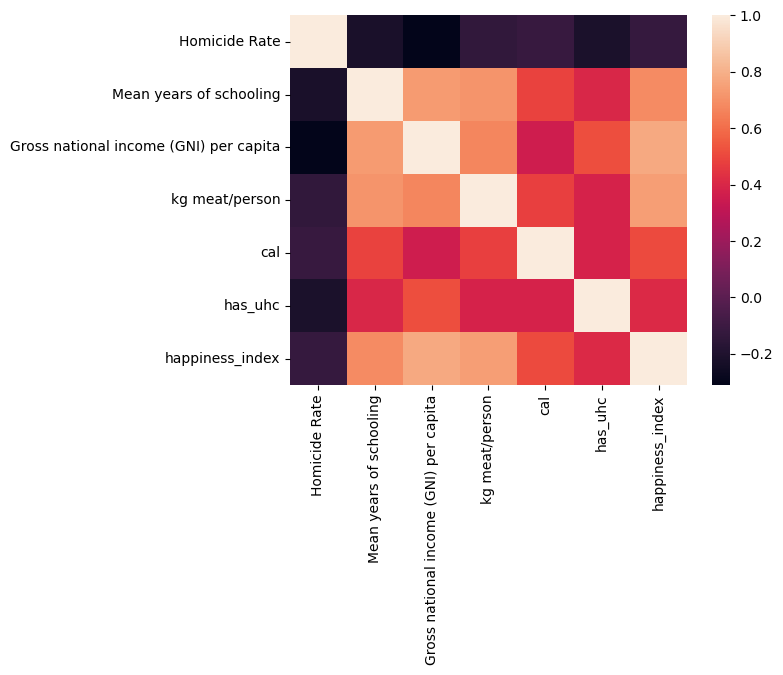

In [38]:
collinearity_matrix = df_final.iloc[:,1:].corr()
sns.heatmap(collinearity_matrix, xticklabels=collinearity_matrix.columns,yticklabels=collinearity_matrix.columns)
collinearity_matrix

### Questions for Reviewers

List specific questions for your peer reviewers
and project mentor to answer in giving you feedback on this phase.